In [38]:
import kagglehub
import os
import pandas as pd
import tensorflow as tf

def download_dataset():
    path = kagglehub.dataset_download("ahmeduzaki/earthquake-alert-prediction-dataset")
    path = os.path.join(path, 'earthquake_alert_balanced_dataset.csv')
    return path

path = download_dataset()

In [39]:
data = pd.read_csv(path)
print(data.head())

   magnitude  depth  cdi  mmi   sig  alert
0        7.0   14.0  8.0  7.0   0.0  green
1        6.9   25.0  4.0  4.0 -33.0  green
2        7.0  579.0  3.0  3.0 -13.0  green
3        7.3   37.0  5.0  5.0  65.0  green
4        6.6  624.0  0.0  2.0 -98.0  green


In [40]:
data.isna().sum()

magnitude    0
depth        0
cdi          0
mmi          0
sig          0
alert        0
dtype: int64

In [41]:
data.shape

(1300, 6)

In [42]:
target = 'alert'
X, y = data[[col for col in data if col != target]], data[target]

In [43]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2)

In [45]:
print(f'X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}')

X_train shape: (1040, 5)
y_train shape: (1040,)


In [46]:
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier(n_estimators=50,
                                             criterion='log_loss')
random_forest_model.fit(X_train, y_train);

In [47]:
preds = random_forest_model.predict(X_test)

In [48]:
print(f'Random Forest acc: {(preds == y_test).mean().item()}')

Random Forest acc: 0.9


In [49]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [50]:
BATCH_SIZE = 32
train_ds = (train_ds
            .shuffle(buffer_size=len(X_train))
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE))

test_ds = (
    test_ds
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [51]:
def normalize(x, y):
    return tf.cast(x, tf.float32) / 255.0, y  # example normalization

train_ds = train_ds.map(normalize)
test_ds = test_ds.map(normalize)

In [52]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [53]:
X_train.shape

(1040, 5)

In [54]:
nn_model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(4, activation='softmax')
])
nn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

c:\Users\s30283\Desktop\dev\iml\venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [55]:
history = nn_model.fit(train_ds, validation_data=test_ds, epochs=300)

Epoch 1/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3596 - loss: 1.3816 - val_accuracy: 0.3500 - val_loss: 1.3781
Epoch 2/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3981 - loss: 1.3627 - val_accuracy: 0.3231 - val_loss: 1.3625
Epoch 3/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4154 - loss: 1.3418 - val_accuracy: 0.3654 - val_loss: 1.3411
Epoch 4/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4221 - loss: 1.3130 - val_accuracy: 0.3808 - val_loss: 1.3122
Epoch 5/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4000 - loss: 1.2812 - val_accuracy: 0.3692 - val_loss: 1.2820
Epoch 6/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4163 - loss: 1.2497 - val_accuracy: 0.3962 - val_loss: 1.2527
Epoch 7/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4058 - loss: 1.2219 - val_accuracy: 0.3885 - val_loss: 1.2251
Epoch 8/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4308 - loss: 1.1994 - val_accuracy: 0.3846 - v

In [57]:
import numpy as np
test_loss, test_acc = nn_model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")

y_pred_probs = nn_model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
print("Sample predictions:", y_pred[:10])


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7423 - loss: 0.6728 
Test accuracy: 0.742
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Sample predictions: [3 2 1 3 0 1 2 3 0 2]


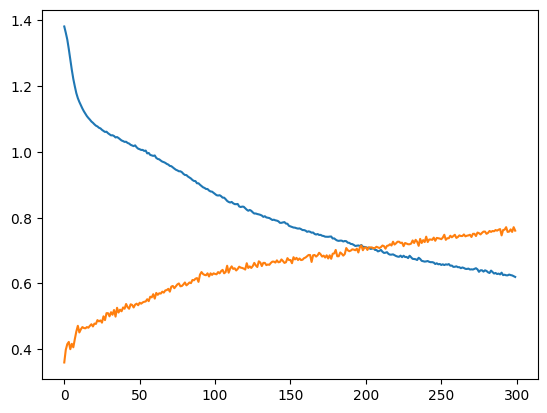

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.show();